###  Description: Predicting Ethereum Price with Python and Machine Learning using Tensorflow and Keras and LSTM

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the data
data = pd.read_csv('ethereum_2015-08-07_2024-09-08.csv')

# Sort data by the 'Start' date
data = data.sort_values('Start')

# Select relevant features
features = data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Convert the scaled features into a DataFrame
scaled_data = pd.DataFrame(scaled_features, columns=features.columns)

# Display the first few rows of the scaled data
print(scaled_data.head())






       Open      High       Low     Close    Volume
0  0.000485  0.000476  0.000062  0.000057  0.000002
1  0.000066  0.000082  0.000044  0.000060  0.000004
2  0.000055  0.000051  0.000046  0.000056  0.000003
3  0.000057  0.000133  0.000051  0.000128  0.000004
4  0.000131  0.000166  0.000098  0.000166  0.000014


### Create Sequences for LSTM

In [2]:
import numpy as np

def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i+sequence_length]
        target = data[i+sequence_length, 3]  # Assuming 'Close' is the target
        sequences.append((sequence, target))
    return sequences

sequence_length = 60  # Example sequence length
sequences = create_sequences(scaled_features, sequence_length)

# Split into training and testing sets
train_size = int(len(sequences) * 0.8)
train_sequences = sequences[:train_size]
test_sequences = sequences[train_size:]

# Prepare the data for the LSTM model
X_train = np.array([seq[0] for seq in train_sequences])
y_train = np.array([seq[1] for seq in train_sequences])
X_test = np.array([seq[0] for seq in test_sequences])
y_test = np.array([seq[1] for seq in test_sequences])


### Build and Train the LSTM Model


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


c:\Users\Student\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - loss: 0.0031 - val_loss: 0.0036
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0010 - val_loss: 0.0040
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 6.2328e-04 - val_loss: 0.0058
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 7.1665e-04 - val_loss: 0.0025
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 5.4522e-04 - val_loss: 0.0022
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 6.7289e-04 - val_loss: 0.0054
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 5.0940e-04 - val_loss: 0.0040
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 7.2941e-04 - val_loss: 0.0027
Epoch 9/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 4.2087e-04 - val_loss: 0.0043
Epoch 10/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 5.5411e-04 - val_loss: 0.0040
Epoch 11/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 4.3982e-04 - val_loss: 0.0023
Epoch 12/20
66/66 ━━━━━━━━

In [4]:
# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')





21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 2.8229e-04
Test Loss: 0.000500288384500891


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step


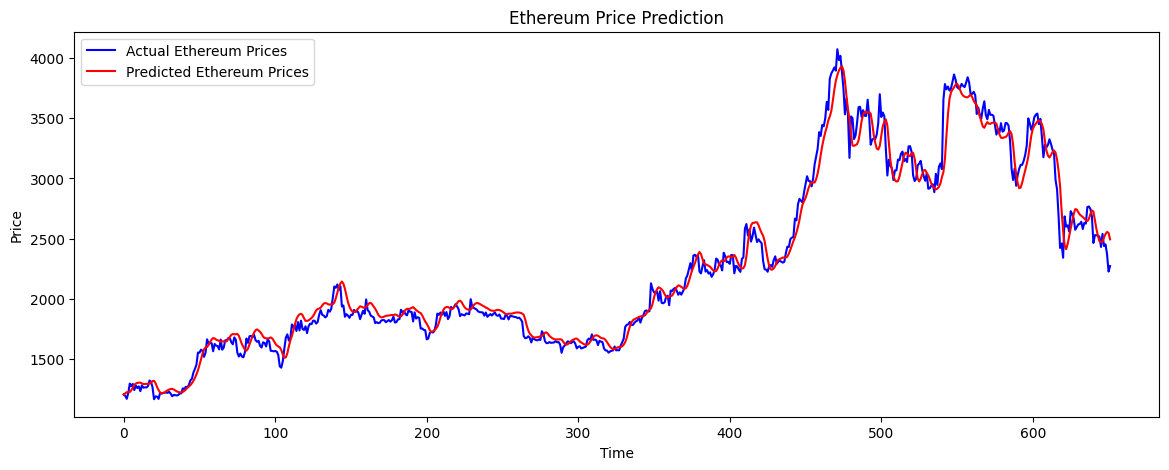

In [5]:
# Make predictions
predictions = model.predict(X_test)


# Reshape the predictions to match the scaler's expected input shape
predictions = predictions.reshape(-1, 1)

# Prepare a dummy array with the same shape as the scaled data (Open, High, Low, Close, Volume)
dummy_array = np.zeros((predictions.shape[0], scaled_features.shape[1]))

# Replace the 'Close' column in the dummy array with the predictions
dummy_array[:, 3] = predictions[:, 0]

# Perform inverse transformation
inverse_transformed_predictions = scaler.inverse_transform(dummy_array)

# Extract the predicted Close prices
predicted_prices = inverse_transformed_predictions[:, 3]

# Invert scaling for actual Close prices
actual_prices = y_test.reshape(-1, 1)
dummy_array = np.zeros((actual_prices.shape[0], scaled_features.shape[1]))
dummy_array[:, 3] = actual_prices[:, 0]
inverse_transformed_actual = scaler.inverse_transform(dummy_array)
actual_prices = inverse_transformed_actual[:, 3]

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(actual_prices, color='blue', label='Actual Ethereum Prices')
plt.plot(predicted_prices, color='red', label='Predicted Ethereum Prices')
plt.title('Ethereum Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


### Save the Model

In [6]:
model.save('ethereum_price_prediction_lstm.keras')


## Load model

In [7]:
from tensorflow.keras.models import load_model

model = load_model('ethereum_price_prediction_lstm.keras')


### Early Stopping: To stop training when the model stops improving.
### Learning Rate Scheduler: To adjust the learning rate during training.

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def create_model():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    
    # Create a new optimizer instance
    optimizer = tf.keras.optimizers.Adam()
    
    # Compile the model with the new optimizer
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model



### Train the model with early stopping:

In [9]:
# Create the model
model = create_model()

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


c:\Users\Student\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 0.0027 - val_loss: 0.0077
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0011 - val_loss: 0.0033
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 7.3294e-04 - val_loss: 0.0073
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 4.1764e-04 - val_loss: 0.0025
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 6.0873e-04 - val_loss: 0.0077
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 4.6309e-04 - val_loss: 0.0024
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 6.1678e-04 - val_loss: 0.0057
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 5.9988e-04 - val_loss: 0.0020
Epoch 9/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 6.2142e-04 - val_loss: 0.0020
Epoch 10/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 4.2214e-04 - val_loss: 0.0031
Epoch 11/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 4.4788e-04 - val_loss: 0.0018
Epoch 12/100
66/

### Hyperparameter Tuning

In [12]:
import kerastuner as kt

def model_builder(hp):
    model = Sequential()
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(LSTM(units=hp_units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=hp_units, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    
    # Choose an optimal learning rate between 0.01 and 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mean_squared_error')
    
    return model

tuner = kt.Hyperband(model_builder,
                    objective='val_loss',
                    max_epochs=20,
                    factor=3,
                    directory='my_dir',
                    project_name='intro_to_kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)


C:\Users\Student\AppData\Local\Temp\ipykernel_4908\214373872.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


Reloading Tuner from my_dir\intro_to_kt\tuner0.json
Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 46s 463ms/step - loss: 0.0037 - val_loss: 0.0040
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 347ms/step - loss: 0.0011 - val_loss: 0.0041
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 335ms/step - loss: 3.4780e-04 - val_loss: 0.0041
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 333ms/step - loss: 5.1208e-04 - val_loss: 0.0022
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 320ms/step - loss: 3.9754e-04 - val_loss: 0.0013
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 326ms/step - loss: 4.4466e-04 - val_loss: 0.0111
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 312ms/step - loss: 3.8845e-04 - val_loss: 0.0023
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 312ms/step - loss: 6.8253e-04 - val_loss: 0.0058
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 314ms/step - loss: 4.2373e-04 - val_loss: 0.0012
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 317ms/step - loss: 2.9881e-04 - val_loss: 0.0014
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 33

# Model Architecture Visualization

In [33]:
import pydot
import graphviz
from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) for `plot_model` to work.


# Training History Visualization

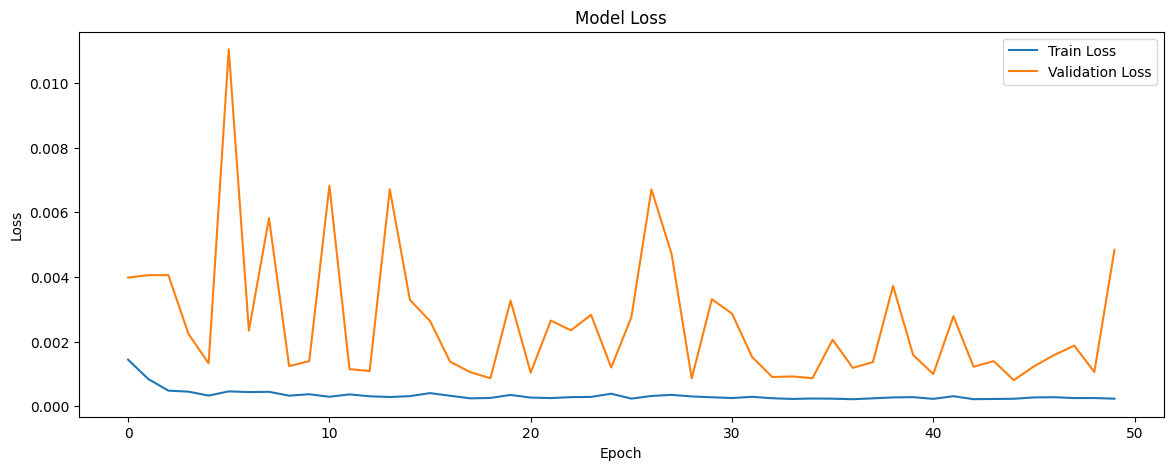

In [21]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


# Prediction Visualization

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step


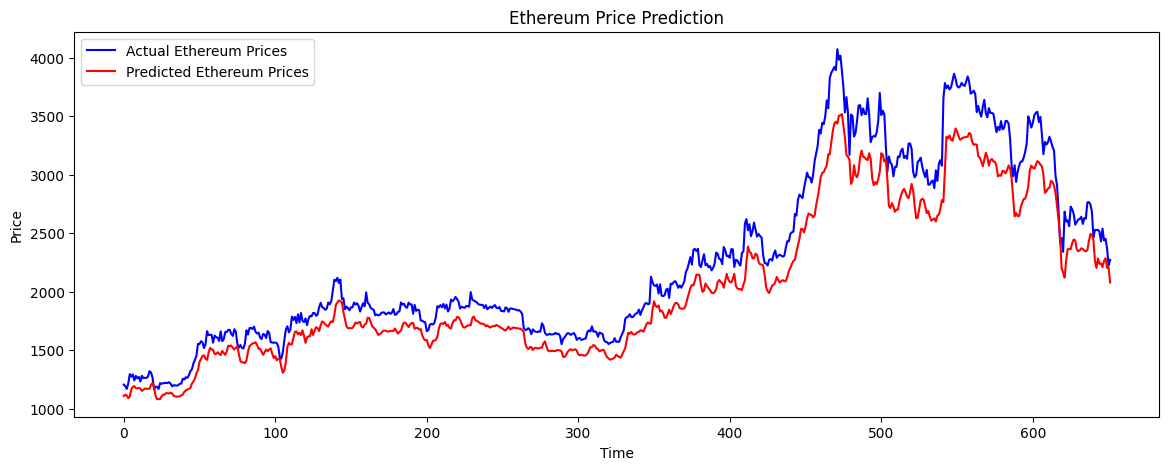

In [22]:
# Make predictions
predictions = model.predict(X_test)

# Reshape the predictions to match the scaler's expected input shape
predictions = predictions.reshape(-1, 1)

# Prepare a dummy array with the same shape as the scaled data (Open, High, Low, Close, Volume)
dummy_array = np.zeros((predictions.shape[0], scaled_features.shape[1]))

# Replace the 'Close' column in the dummy array with the predictions
dummy_array[:, 3] = predictions[:, 0]

# Perform inverse transformation
inverse_transformed_predictions = scaler.inverse_transform(dummy_array)

# Extract the predicted Close prices
predicted_prices = inverse_transformed_predictions[:, 3]

# Invert scaling for actual Close prices
actual_prices = y_test.reshape(-1, 1)
dummy_array = np.zeros((actual_prices.shape[0], scaled_features.shape[1]))
dummy_array[:, 3] = actual_prices[:, 0]
inverse_transformed_actual = scaler.inverse_transform(dummy_array)
actual_prices = inverse_transformed_actual[:, 3]

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(actual_prices, color='blue', label='Actual Ethereum Prices')
plt.plot(predicted_prices, color='red', label='Predicted Ethereum Prices')
plt.title('Ethereum Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [23]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Assuming X_test and y_test are already defined and you have a trained model

# Make predictions on the test set
y_pred = model.predict(X_test)

# If you used a MinMaxScaler or any other scaler on your y values, you'll need to inverse transform
# Assuming you used a MinMaxScaler called scaler_y to scale your y values:
# y_pred = scaler_y.inverse_transform(y_pred)
# y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Flatten the predictions and actual values if they have more than 1 dimension
y_pred = y_pred.flatten()
y_test = y_test.flatten()

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared (R²)
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

# If you want an accuracy score (though typically not used in regression)
# Define an accuracy metric, e.g., percentage of predictions within a certain threshold of actual value
accuracy = np.mean(np.abs(y_test - y_pred) <= 0.1 * y_test) * 100
print(f"Accuracy: {accuracy}%")


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step
Mean Squared Error: 0.0028846640197950292
R-squared: 0.8804677249222577
Accuracy: 61.809815950920246%
